# Before you start: Install Tensorflow and Keras

This assignment requires to install Keras. Using Anaconda, this should be simple:

`conda install keras`

That's it. If you get any conda package conflits, it may be convenient to create a new conda environment:

`conda create -n tf2 tensorflow=2.3.0 jupyter python=3.7 matplotlib seaborn scikit-learn`

This will create a conda environment with the name `tf2` and install tensorflow 2 (including Keras), jupyter notebook, matplotlib, seaborn and python 3.7. You can switch to the newly created `tf2` environment by typing

`source activate tf2` 

And then run

`jupyter notebook`

in the same terminal to open a jupyter notebook. 

_Note that after performing the install, you need to restart this notebook for the changes to take effect._

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Keras imports
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

2.7.0
2.7.0


In [2]:
def prepare_data(use_classes = [0,8], return_shape_y='matrix',return_shape_x='flat',n_trainex_per_class='all'):
    '''Wrapper function that returns preprocessed training and validation data from the famous MNIST data set
    
    Note: Class labels are _always_ re-assigned such that the class labels returned are in range 0:n_classes 
    (i.e. if you request classes 2 and 8, you will still get labels 0 and 1 out)
    
    input arguments:
        use_classes: list of integers (values from 0-9 in any order)
        Only examples from the classes in this list will be returned
        
        return_shape_y: string ('matrix' or 'vector')
        'matrix' will return a one-hot class encoding of the labels with shape (n_examples x n_classes)
        'vector' will return a list of labels with length (n_examples)
        
        return_shape_x: string ('flat', 'channels' or 'image')
        'flat' will return input images as flattened arrays (n_examples x n_pixels)
        'image' will return input images as stacked images (n_examples x n_rows x n_columns)
        'channels' will return input images as stacked images with an additional channel dimension that tensorflow requires for convolutions
        shape for 'channels' will be either (n_examples x n_rows x n_columns x 1) or (n_examples x 1 x n_rows x n_columns), depending on your keras system settings
        
        n_trainex_per_class: int (values up to 5421 will work (5421 = number of example in smallest class))
        
        
    returns:
        (x_train, y_train): tuple of arrays
            x_train: training set images with shape defined by return_shape_x
            y_train: training set labels with shape defined by return_shape_y
        
        (x_test, y_test): tuple of arrays
            x_test: test set images with shape defined by return_shape_x
            y_test: test set labels with shape defined by return_shape_y
        
        num_classes: int
            number of classes used
        '''
    
    
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # input image dimensions
    img_rows, img_cols = 28, 28

    # find and use only examples of chosen classes
    train_idx = np.isin(y_train,use_classes)
    test_idx = np.isin(y_test,use_classes)
    x_train = x_train[train_idx,:,:]
    y_train = y_train[train_idx]
    x_test = x_test[test_idx,:,:]
    y_test = y_test[test_idx]
    
    # if required, use fewer training examples per class
    if not n_trainex_per_class=='all':
        y_smaller = []
        x_smaller = []
        for c in use_classes:
            class_idx = np.where(y_train==c)[0][:n_trainex_per_class]
            y_smaller.append(y_train[class_idx])
            x_smaller.append(x_train[class_idx,:,:])
        y_train = np.concatenate(y_smaller)
        x_train = np.concatenate(x_smaller)

    # make new class labels that are 0:n_classes (needed for later use of 'keras.utils.to_categorical')
    new_class_ids_mapping = {old_id:new_id for new_id,old_id in enumerate(use_classes)}
    num_classes = len(use_classes)
    y_test = np.array([new_class_ids_mapping[y] for y in y_test])
    y_train = np.array([new_class_ids_mapping[y] for y in y_train])

    # normalize images and print shape
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # if requested convert class vectors to binary class matrices
    if return_shape_y=='matrix':
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
    # otherwise return as vector
    elif return_shape_y=='vector':
        pass
    else:        
        raise Exception('unknown return_shape_y')
    
    if return_shape_x=='flat':
        # flatten image data
        x_train = x_train.reshape(len(y_train), img_rows*img_cols)
        x_test = x_test.reshape(len(y_test), img_rows*img_cols)

    elif return_shape_x =='channels':
        # reshape to add channel dimension (being aware of the keras system setting)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
    elif return_shape_x == 'image':
        pass
    
    else:
        raise Exception('unknown return_shape_x')

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
        
    return (x_train, y_train), (x_test, y_test), num_classes

# Task 0: Explore the dataset

We load the full MNIST dataset as provided by `tensorflow.keras.datasets.mnist` and plot 10 examples of each class in a 10x10 plot. 

In [10]:
# load data
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes=list(range(10)),return_shape_y='vector',return_shape_x='image',n_trainex_per_class=10)

100 train samples
10000 test samples
x_train shape: (100, 28, 28)
y_train shape: (100,)


In [11]:
# for later use
n_rows = x_train.shape[1]
n_clms = x_train.shape[2]

In [12]:
x_train.shape

(100, 28, 28)

In [13]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

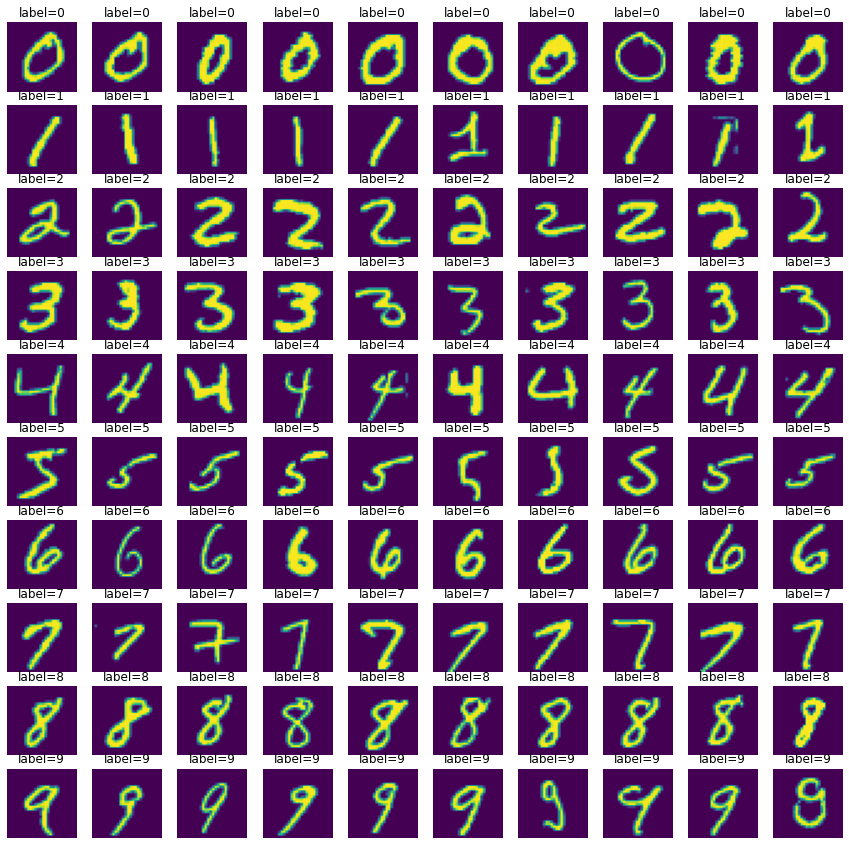

In [14]:
# display the first few examples
fig,axes = plt.subplots(10,10,figsize=(15,15))
axes=axes.flatten()
for i,ax in enumerate(axes):
    
    ax.imshow(x_train[i,:,:])
    ax.set_title('label=%u' % (y_train[i]))
    sns.despine()
    ax.axis('off')
plt.show()

# Task 1: LDA (15 points)

For the rest of the notebook, we will restrict ourselves to the classes `3` and `8`, and also to a subset of examples (`500` per class).

First, use Linear Discriminant Analysis to separate the classes. Here you will need to find a weight vector $\vec{w}$ so that the classes are optimally separated in the projections $p_i =   \vec{w}^T \vec{x}_i$ of data points $\vec{x}_i$.

In [15]:
classes = [3,8]
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_y='vector',return_shape_x='flat',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000,)


In [16]:
y_train[480:520]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
28*28

784

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

Note: In cases like ours where $n_{features}$ isn't much smaller than $n_{samples}$, the within-class covariance matrix is not invertible. To fix this, we can add a small constant to the diagonal of it, which is equivalent to ridge regularization. Play a bit with the value of the pentaly to see its effect and find a value that gives good results.

You can rely on the fact that there is the same number of samples in each class (it simplifies some of the formulas).

In [53]:
def compute_lda_weights(x,y,alpha=1):
    '''function that computes regularized LDA weights for a two class problem
    
    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float
        
    returns:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''
    
    # covariances per class
    cov0 = np.cov(x[y==0,:],rowvar=False)  
    cov1 = np.cov(x[y==1,:],rowvar=False)
    # means per class
    m0 = np.mean(x[y==0,:],axis=0)
    m1 = np.mean(x[y==1,:],axis=0)
    mdiff = m1-m0
    
    # invert within-class covariance matrix
    # add small constant variance to diagonal
    const = np.eye(n_rows*n_clms)*alpha
    S_within = cov0+cov1+const
    S_within_inv = np.linalg.inv(S_within)

    # get optimal projection vector w
    w = S_within_inv @ mdiff
    
    return m0,m1,mdiff,w

As  $\vec{w}$ has the dimensionality of our input data, we can interpret it as image with the same size as the training examples. Reshape the weight vector accordingly and plot the resulting 'weight image'. Describe and interpret the image.

In [54]:
def plot_weight_image(flat_data,im_dim,titlestr):
    '''Function that takes a flat vector with the same dimensionality as the input data 
    and plot it as an image of the shape of the original images'''
    
    plt.title(titlestr)
    img = plt.imshow(np.reshape(flat_data,im_dim))

In [55]:
# compute weights
m0,m1,mdiff,w = compute_lda_weights(x_train,y_train,alpha=1)

# vizualize input data and resulting weight vector
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_weight_image(m0,(n_rows,n_clms),'mean image class 0')
plt.subplot(1,4,2)
plot_weight_image(m1,(n_rows,n_clms),'mean image class 1')
plt.subplot(1,4,3)
plot_weight_image(mdiff,(n_rows,n_clms),'mean image difference')
plt.subplot(1,4,4)
plot_weight_image(w,(n_rows,n_clms),'LDA projection weights in image space')
plt.show()

ADD YOUR ANSWER HERE

Something like:
1. mean denotes numbers as expected
2. mean image difference is 8-3, 3 pixels are blueer
3. LDA is a scaled and rotated version of the mean difference, due to the within-covariance

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. Is the separation good? Is there a big difference between training and test data?

In [56]:
print('x_train shape: ', x_train.shape, '\nand w shape: ', w.shape)

x_train shape:  (1000, 784) 
and w shape:  (784,)


In [57]:
# Compute the projections for training and test data

x_train_proj = np.dot(x_train,w.T)
x_test_proj = np.dot(x_test,w.T)    

In [16]:
def projection_histogram(x_proj,y,titlestr='',threshold='none'):
    '''Function that projects data x on a LDA weight vector w and plots the projection values separately by class
    
        input:
        x_proj: input data -- flat array with length (n_examples)
        y: class labels -- flat array with length (n_examples)
        titlestr: histogram title string
        threshold: threshold value (float) or 'none' (string) to not plot a threshold        
    '''
    
    plt.hist(x_proj[y==0],label='class 0',alpha=0.5)
    plt.hist(x_proj[y==1],label='class 1',alpha=0.5)
    if threshold!='none':
        plt.vlines(threshold,0,400,label='threshold')
    plt.title(titlestr)
    sns.despine()
    plt.legend()    

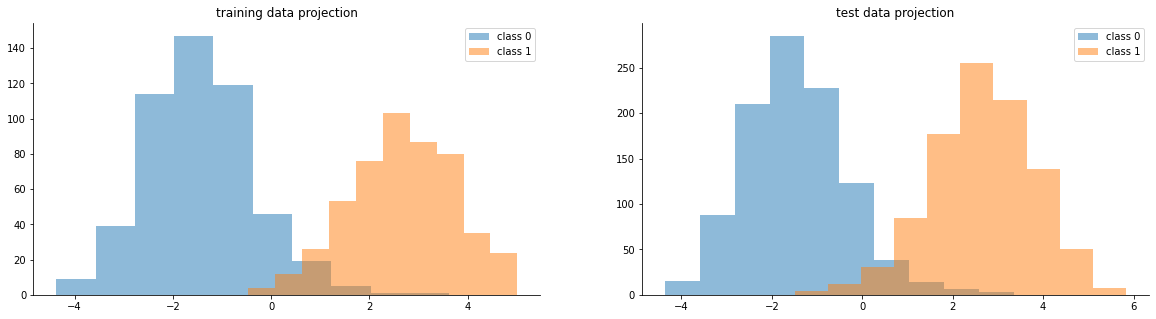

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection')
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection')
plt.show()

ADD YOU ANSWER HERE
Separation is already good. Some overlap present, reasonably more for test as training, expected.

Now we make class predictions based on the projections. Compute the threshold $c$ for projected values $p_i$ based on the training data (assigning each point to the class with higher posterior probability; assuming balanced classes, that's the same as higher likelihood). Print the value of $c$ and plot $c$ into the histograms of projected values you made before. You can use the fact that the classes are balanced.

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

In [18]:
def opt_c_LDA(m0,m1,w):
    '''Compute the optimal threshold for LDA 
    
    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)
        
    output:
        c: the optimal threshold for LDA
         
    '''
    
    c = np.dot((m0+m1)/2,w.T)  
    return c

In [19]:
def score_LDA(x_proj,y,c):
    '''Compute the optimal threshold for LDA and the return the error 
    based on thresholding projected values
    
    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar
        
    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        error: classification error
        
    '''
    
    y_hat = np.array(x_proj) > c
    error =  1 - np.mean(y_hat == y)
    
    return y_hat, error

In [20]:
y_hat=np.array(x_train_proj)>np.dot((m0+m1)/2, w.T)

In [21]:
c = opt_c_LDA(m0,m1,w)

y_hat_train, error_train = score_LDA(x_train_proj,y_train,c)
y_hat_test, error_test = score_LDA(x_test_proj,y_test,c)

# show threshold in histograms
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection with threshold',c)
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection with threshold',c)
plt.show()

# print training and test set accuracy
print("Training set error (LDA): ", error_train)
print("Test set error (LDA):     ", error_test)

Training set error (LDA):  0.03400000000000003
Test set error (LDA):      0.040322580645161255


GRADING

code = 7 points; 
figures = 5 points; 
explanations = 3 points

## Task 2: MNIST with Logistic Regression (15 points)

Now we will use logistic regression, again using `sklearn`. To make sure results are comparable, set the parameters `random_state=1` and `solver='saga'` when you define the models. Also, if you get convergence warnings choose a larger `max_iter` until all your models converge. You should not need more than 5000 iterations. Use the `n_jobs` parameter to control multiprocessing behavior (this can give a good speed-up for the later parts of this task if you have multiple CPU cores).

### Unregularized logistic regression
First, fit an unregularized logistic regression model using `sklearn`'s `LogisticRegression()`, and use `sklearn`'s in-built scoring function to get a test set error.

In [22]:
# define model
logreg_base = LogisticRegression(penalty='none',random_state=1,solver='saga',verbose=1,max_iter=5000,n_jobs=-1)

# fit
logreg_base.fit(x_train,y_train)

# score
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.


convergence after 1821 epochs took 22 seconds
Test set error (LogReg - no regularization) : 0.05241935483870963


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.2s finished


### Ridge and Lasso with CV
Next, we will use Lasso and Ridge regularized logistic regression

Use `sklearn`'s `LogisticRegressionCV()` model to run a 10-fold crossvalidation over ten different log-spaced regularization strengths to find an optimal regularization strength; do this for both Lasso and Ridge regularization. Hint: Watch out for the parametrisation `sklearn` uses to pass the regularization strength. Note that this can take a few minutes to run.

In [23]:
%%time

# set shared hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
logreg_lasso_cv = LogisticRegressionCV(Cs=n_alphas,penalty='l1',solver='saga',n_jobs=-1,verbose=1,max_iter=max_iter,cv=n_folds,random_state=1)
logreg_ridge_cv = LogisticRegressionCV(Cs=n_alphas,penalty='l2',solver='saga',n_jobs=-1,verbose=1,max_iter=max_iter,cv=n_folds,random_state=1)

# fit models
logreg_ridge_cv.fit(x_train,y_train)
logreg_lasso_cv.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...

convergence after 539 epochs took 4 seconds
convergence after 101 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   30.3s remaining:    7.6s


convergence after 100 epochs took 1 seconds
convergence after 99 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 3 epochs took 0 

[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.1min remaining:   16.5s


convergence after 569 epochs took 6 seconds
convergence after 133 epochs took 1 seconds
convergence after 18 epochs took 0 seconds
convergence after 710 epochs took 7 seconds
convergence after 165 epochs took 1 seconds
convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


CPU times: user 15min 44s, sys: 49 s, total: 16min 33s
Wall time: 1min 55s


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=5000, multi_class='auto', n_jobs=-1, penalty='l1',
                     random_state=1, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=1)

Plot crossvalidation curves for both lasso and ridge regularized logisitic regression: Plot regularization strength $\alpha$ vs. accuracy for each fold. Indicate the average accuracy across folds and mark the average score with optimal $\alpha$. In the code below, we already convert the sklearn parametrization of the regularization strength to a standard format.

In [24]:
def plot_cv_curves(alphas, cv_scores):
    '''Function that plots CV results: data from each fold/alpha combination,
    average over fold and a special mark for the optimal alpha.
    
    inputs: 
        alphas - flat array with alphas used in the CV, length (n_alphas)
        cv_scores - array accuracy values for each score/alpha combination, shape (n_folds x n_alphas)
    '''
    
    #plot scores for each folds
    plt.plot(alphas,cv_scores.T,'.',alpha=0.25,c='tab:blue')
    #plot average score
    avg_scores = np.mean(cv_scores,axis=0)
    plt.plot(alphas,avg_scores,'k',alpha=0.6,label='average')
    
    #mark the best model
    best_alpha_idx = np.argmax(avg_scores)
    best_alpha = alphas[best_alpha_idx]
    best_alpha_avgscore = avg_scores[best_alpha_idx]    
    plt.plot(best_alpha,best_alpha_avgscore,'rx',label='best model (alpha=%.4f)' % (best_alpha))
        
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.gca().set_xscale('log')
    
    plt.legend()    
    sns.despine()

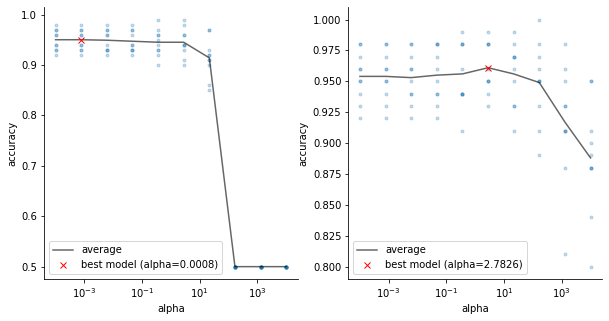

In [25]:
# alphas_lasso = 1/logreg_lasso_cv.Cs_
# alphas_ridge = 1/logreg_ridge_cv.Cs_
alphas_lasso = logreg_lasso_cv.Cs_[::-1]
alphas_ridge = logreg_ridge_cv.Cs_[::-1]
cv_scores_lasso = logreg_lasso_cv.scores_[1]
cv_scores_ridge = logreg_ridge_cv.scores_[1]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_cv_curves(alphas_lasso,cv_scores_lasso)
plt.subplot(1,2,2)
plot_cv_curves(alphas_ridge,cv_scores_ridge)
plt.show()

For both Lasso and Ridge, show how the 'weight images' change as a function of regularization strength. Plot one weight image per regularization strength value. Use `plt.colorbar()` to show the color-value mapping next to each plot so you can also see if the range of values changes. Describe and interpret what you observe.

In [26]:
def plot_weight_image_evolution(alphas,coefs_paths):
    '''function that plots weight image change with alphas'''

    fig,axes=plt.subplots(2,np.ceil(len(alphas)/2).astype(int),figsize=(15,5))

    for c,ax in enumerate(axes.flatten()):
        weights = coefs_paths[0,c,:784]
        titlestr = 'alpha: %.4f' % (alphas[c])
        img = ax.imshow(np.reshape(weights,(n_rows,n_clms)))
        ax.set_title(titlestr)
        ax.axis('off')
        fig.colorbar(img,ax=ax,shrink=0.5)

In [27]:
plot_weight_image_evolution(alphas_lasso,logreg_lasso_cv.coefs_paths_[1])
plt.suptitle('Lasso')
plt.show()

plot_weight_image_evolution(alphas_ridge,logreg_ridge_cv.coefs_paths_[1])
plt.suptitle('Ridge')
plt.show()

In [ ]:
x_train.shape

In [ ]:
x_test.shape

YOUR ANSWER HERE
Big lasso = many weight values equal to zero, as expected. The images seem to be pretty noisy. Big ridge also leads to smaller values, as expected. In addition it seems to converge to the mean difference, for even higher values of ridge it would have to remain to be seen whether that's still true. Images corresponding to highest performance also noisy. Much noisier than LDA.

Compare the test error of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model, using `sklearn`'s inbuilt function.


In [56]:
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))
print("Test set error (LogReg - ridge) :", 1 - logreg_ridge_cv.score(x_test,y_test))
print("Test set error (LogReg - lasso) :", 1 - logreg_lasso_cv.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.05241935483870963
Test set error (LogReg - ridge) : 0.03931451612903225
Test set error (LogReg - lasso) : 0.05393145161290325


Plot 'weight images' of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model. Describe and interpret the differences you observe. Also compare to the weight image obtained with LDA!

In [29]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plot_weight_image(logreg_base.coef_,(n_rows,n_clms),'LogReg \n no regularization')
plt.colorbar(shrink=0.8)

plt.subplot(2,2,2)
plot_weight_image(logreg_lasso_cv.coef_,(n_rows,n_clms),'LogReg + Lasso regularization \n Best model')
plt.colorbar(shrink=0.8)

plt.subplot(2,2,3)
plot_weight_image(logreg_ridge_cv.coef_,(n_rows,n_clms),'LogReg + Ridge regularization \n Best model')
plt.colorbar(shrink=0.8)

plt.subplot(2,2,4)
plot_weight_image(w,(n_rows,n_clms),'LDA weights')
plt.colorbar(shrink=0.8)

plt.show()

YOUR ANSWER HERE LDA= nice scaled and rotated mean difference, lasso and ridge LG arguably a bit less noisy then pure LG (no regularization), lasso has more zero weight values.

GRADING
code 7 points; figures 5 points; explanations 3 points

## Task 3: MNIST with simple Keras Fully connected neural network  (10 points)

Now we use the Keras library that provides easy access to custom neural network implementation. If you look for a tutorial, try this:

https://keras.io/getting-started/sequential-model-guide/

In the two Keras tasks (Task 3 & 4), your job is to play with the hyperparameters and find an architecture that works and, in the best case, outperforms the more simple models from before that reached about 95% test set performance.

We start with a fully connected network - which is basically a logistic regression, with an added layers of hidden units.

In [21]:
# loading the data in a format suitable for Keras and fully connected networks (flat inputs)
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='flat',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000, 2)


Create a Keras model with two fully connected hidden layers that takes our (flattened) images as input and outputs a softmax class score for both classes. Use `.summary()` to display the model's structure.

You can experiment with different sizes of the hidden layers, and you can also experiment with adding Dropout layers if you want (this was not covered in the lecture, so is strictly optional).

In [22]:
# hyperparameter
n_hidden_units = 23
# dropout_strength = 0.2

# define model
model_fcn = Sequential()
model_fcn.add(Dense(n_hidden_units, activation='relu', input_shape=(n_rows*n_clms,)))
# model_fcn.add(Dropout(dropout_strength))
model_fcn.add(Dense(n_hidden_units, activation='relu'))
model_fcn.add(Dense(n_hidden_units, activation='relu'))
# model_fcn.add(Dropout(dropout_strength))
model_fcn.add(Dense(num_classes, activation='softmax'))

# print model structure
model_fcn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 23)                18055     
                                                                 
 dense_7 (Dense)             (None, 23)                552       
                                                                 
 dense_8 (Dense)             (None, 23)                552       
                                                                 
 dense_9 (Dense)             (None, 2)                 48        
                                                                 
Total params: 19,207
Trainable params: 19,207
Non-trainable params: 0
_________________________________________________________________


Set up the model optimization with `compile()`: use stochastic gradient descent (`SGD()`) with default settings (but you can also try adaptive optimizers, such as `Adam()` if you want). Use a crossentropy loss. Make sure Keras saves the `accuracy` metric for each epoch of the optimization.

Train the network on the training set for 100 epochs, and specify the test set as  `validation_data` in your call to `.fit()`. Make sure you save the output of `.fit()` to a variable.

In [23]:
from tensorflow.keras import metrics

In [24]:
# hyperparameters
batch_size = 128
epochs = 100

# choose loss and optimzer
model_fcn.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=[metrics.BinaryAccuracy(
    name="accuracy", dtype=None, threshold=0.5
)])

# fit model, return training history
history_fcn = model_fcn.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/8 [==>...........................] - ETA: 2s - loss: 0.7115 - accuracy: 0.5312WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0b16f2ed40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

Epoch 46/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1000 - accuracy: 0.9670 - val_loss: 0.1247 - val_accuracy: 0.9587
Epoch 47/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0976 - accuracy: 0.9700 - val_loss: 0.1243 - val_accuracy: 0.9582
Epoch 48/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9700 - val_loss: 0.1231 - val_accuracy: 0.9587
Epoch 49/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0942 - accuracy: 0.9690 - val_loss: 0.1227 - val_accuracy: 0.9587
Epoch 50/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9690 - val_loss: 0.1216 - val_accuracy: 0.9592
Epoch 51/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0917 - accuracy: 0.9700 - val_loss: 0.1210 - val_accuracy: 0.9592
Epoch 52/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0893 - accuracy: 0.9710 - val_loss: 0.1205 - val_accuracy: 0.9587
Epoch 53/100
8/8 

Report the test set error and loss.

In [25]:
# get final test set evaluation
score = model_fcn.evaluate(x_test, y_test, verbose=0)

print("Test set error (Dense NN):", 1 - score[1])
print("Test set loss (Dense NN): ", score[0])

Test set error (Dense NN): 0.037298381328582764
Test set loss (Dense NN):  0.11372257769107819


Plot the trajectories of loss and accuracy for both test and training set, using the `history` object that `.fit()` returns. Describe how test and training loss behave over epochs. What do you observe and why?

In [26]:
def plot_history(history):
    '''Takes the history object returned by Keras' ´.fit()´ function and
    plots loss and accuracy curves for both training and validation set '''
    plt.figure(figsize=(15,3.5))

    plt.subplot(1,2,1)
    plt.plot(history.epoch,history.history['loss'],label='Training set loss')
    plt.plot(history.epoch,history.history['val_loss'],label='Test set loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    sns.despine()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.epoch,history.history['accuracy'],label='Training set accuracy')
    plt.plot(history.epoch,history.history['val_accuracy'],label='Test set accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    sns.despine()
    plt.legend()
    plt.show()

In [27]:
plot_history(history_fcn)

YOUR ANSWER HERE
Train and test set loss decrease until more overfitting happens and test set loss does not really decrease anymore. That signals the time to stop. This is reflected as well when we look at the accuracy metric we've been looking at before. Note that the loss is the categorical entropy loss, and a different one to that which measures accuracy.

GRADING

Code=6 points; figures = 2.5 points; explanation = 1.5 points.

## Task 4: MNIST with simple Keras CNN  (10 points)

In [28]:
# load the data in a conv net & keras friendly format
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='channels',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 2)


We defined a Keras model with convolutional layers and a fully connected top layer that outputs a softmax class score for both classes. Use `.summary()` to display the model's structure. Play with the hyperparameters such that you get roughly the same number of parameters as in the fully connected network above, yet outperform it.

In [29]:
# hyperparameters
input_shape = x_train.shape[1:]
n_features_conv1 = 8 
n_features_conv2 = 16
n_features_top = 10 
kernel_size = 11
pool_size = 2

#define model
model = Sequential()
model.add(Conv2D(n_features_conv1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(n_features_conv2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(n_features_top, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# show model structure
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 18, 18, 8)         976       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          15504     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                2570      
                                                                 
 dense_11 (Dense)            (None, 2)                 22        
                                                      

Configure the optimization as in Task 3 and train for 100 epochs as in Task 3.

In [30]:
batch_size = 128
epochs = 100

# choose loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=[metrics.BinaryAccuracy(
    name="accuracy", dtype=None, threshold=0.5
)])

# fit model and return history
history_cnn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5480WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f0b7d84c440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

Epoch 46/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0857 - accuracy: 0.9740 - val_loss: 0.1030 - val_accuracy: 0.9622
Epoch 47/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0915 - accuracy: 0.9660 - val_loss: 0.0931 - val_accuracy: 0.9688
Epoch 48/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0858 - accuracy: 0.9700 - val_loss: 0.0925 - val_accuracy: 0.9682
Epoch 49/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0845 - accuracy: 0.9710 - val_loss: 0.0978 - val_accuracy: 0.9672
Epoch 50/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0821 - accuracy: 0.9730 - val_loss: 0.0944 - val_accuracy: 0.9652
Epoch 51/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0786 - accuracy: 0.9740 - val_loss: 0.1018 - val_accuracy: 0.9612
Epoch 52/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0794 - accuracy: 0.9710 - val_loss: 0.0895 - val_accuracy: 0.9698
Epoch 53/100


As in Task 3, print test set loss and error and plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

Test set error (Conv NN): 0.025201618671417236
Test set loss (Conv NN):  0.07715225964784622


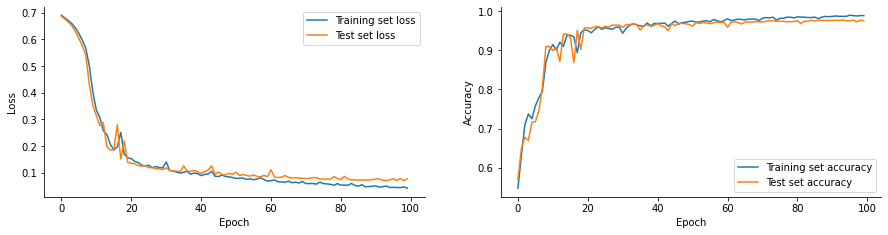

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)

print("Test set error (Conv NN):", 1 - score[1])
print("Test set loss (Conv NN): ", score[0])

plot_history(history_cnn)

ANSWER slightly more noise, curves as above, but training and test error are tighter. This overall performs the best which is perhaps expected from the power of using CNNs. MNIST is a relatively easy dataset, however, so also LDA and LG perform well enough.

GRADING
code = 6 points, figures = 2.5 points, explanation = 1.5 points.